In [46]:
import numpy as np
from shapely.geometry import Polygon, LineString
from shapely.ops import split

def split_polygon_by_horizontal_grid(polygon: Polygon, n: int) -> list:
    """
    Split a polygon into n parts using horizontal grid lines that are perpendicular
    to the polygon's general orientation.
    
    Args:
        polygon: Shapely Polygon to be split
        n: Number of parts to split into
        
    Returns:
        List of Shapely Polygons resulting from the split
    """
    if not isinstance(polygon, Polygon):
        raise ValueError("Input must be a Shapely Polygon")
    if n <= 1:
        return [polygon]
    
    # Get the minimum rotated rectangle to determine orientation
    mrr = polygon.minimum_rotated_rectangle
    coords = np.array(mrr.exterior.coords)
    
    # Find the longest edge of the rotated rectangle to determine orientation
    edges = [LineString([coords[i], coords[i+1]]) for i in range(3)]
    longest_edge = max(edges, key=lambda e: e.length)
    
    # Calculate the angle of the longest edge
    x0, y0 = longest_edge.coords[0]
    x1, y1 = longest_edge.coords[1]
    angle = np.arctan2(y1 - y0, x1 - x0)
    
    # Create cutting lines perpendicular to the orientation
    bounds = polygon.bounds
    minx, miny, maxx, maxy = bounds
    
    # Calculate cutting line parameters
    if np.abs(angle) < np.pi/4:
        # More horizontal than vertical - cut vertically
        cut_direction = 'vertical'
        cut_positions = np.linspace(minx, maxx, n+1)[1:-1]
        lines = [
            LineString([(x, miny - 1), (x, maxy + 1)]) 
            for x in cut_positions
        ]
    else:
        # More vertical than horizontal - cut horizontally
        cut_direction = 'horizontal'
        cut_positions = np.linspace(miny, maxy, n+1)[1:-1]
        lines = [
            LineString([(minx - 1, y), (maxx + 1, y)]) 
            for y in cut_positions
        ]
    
    # Perform the splitting
    parts = [polygon]
    for line in lines:
        new_parts = []
        for part in parts:
            try:
                split_result = split(part, line)
                if split_result.is_empty:
                    new_parts.append(part)
                else:
                    new_parts.extend(list(split_result.geoms))
            except:
                new_parts.append(part)
        parts = new_parts
    
    # Filter out any zero-area polygons that might have been created
    parts = [p for p in parts if not p.is_empty and p.area > 0]
    
    return parts

Error processing file: 'None of [RangeIndex(start=0, stop=2, step=1)] are in the [columns]'


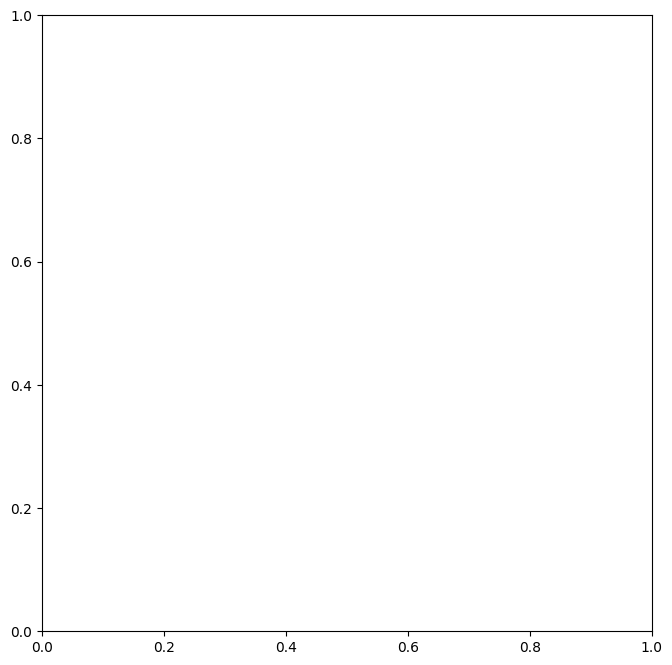

In [45]:
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
import matplotlib.pyplot as plt

def flatten_geometries(gdf):
    """Flatten MultiPolygons into individual Polygons."""
    polygons = []
    for geom in gdf.geometry:
        if geom.is_empty:
            continue
        if isinstance(geom, Polygon):
            polygons.append(geom)
        elif isinstance(geom, MultiPolygon):
            polygons.extend([g for g in geom.geoms if isinstance(g, Polygon)])
    return polygons

def process_geojson(input_path, output_path, n_splits=5, plot_result=True):
    """
    Process a GeoJSON file by splitting each polygon into n parts.
    
    Args:
        input_path: Path to input GeoJSON file
        output_path: Path to save output GeoJSON file
        n_splits: Number of splits to make per polygon
        plot_result: Whether to plot the results
    """
    # Load and validate GeoJSON
    try:
        gdf = gpd.read_file(input_path)
        if gdf.empty:
            raise ValueError("GeoJSON file is empty")
    except Exception as e:
        raise ValueError(f"Error loading GeoJSON: {str(e)}")

    # Set CRS if not present (default to WGS84)
    if gdf.crs is None:
        gdf = gdf.set_crs(epsg=4326)
    
    # Project to meter-based CRS for accurate splitting
    gdf_proj = gdf.to_crs(epsg=3857)
    
    # Flatten MultiPolygons
    flat_polys = flatten_geometries(gdf_proj)
    if not flat_polys:
        raise ValueError("No valid polygons found in the input file")
    
    # Split all polygons
    all_parts = []
    for poly in flat_polys:
        try:
            split_parts = split_polygon_by_horizontal_grid(poly, n=n_splits)
            all_parts.extend(split_parts)
        except Exception as e:
            print(f"Warning: Failed to split polygon - {str(e)}")
            all_parts.append(poly)  # Keep original if split fails
    
    # Create result GeoDataFrame and reproject to WGS84
    result_gdf = gpd.GeoDataFrame(geometry=all_parts, crs=gdf_proj.crs)
    result_gdf = result_gdf.to_crs(epsg=4326)
    
    # Plot results if requested
    if plot_result:
        fig, ax = plt.subplots(figsize=(10, 8))
        result_gdf.plot(ax=ax, alpha=0.6, edgecolor='black', column=result_gdf.index)
        plt.title(f"Split Results (n={n_splits})")
        plt.show()
    
    # Save to file
    try:
        result_gdf.to_file(output_path, driver="GeoJSON")
        print(f"Successfully saved results to {output_path}")
    except Exception as e:
        raise IOError(f"Error saving results: {str(e)}")

    return result_gdf

# Example usage
if __name__ == "__main__":
    input_file = "testes.geojson"
    output_file = "hasil_split.geojson"
    
    try:
        result = process_geojson(input_file, output_file, n_splits=5)
    except Exception as e:
        print(f"Error processing file: {str(e)}")

Original area: 27.00
Number of parts: 1
Part 1 area: 27.00


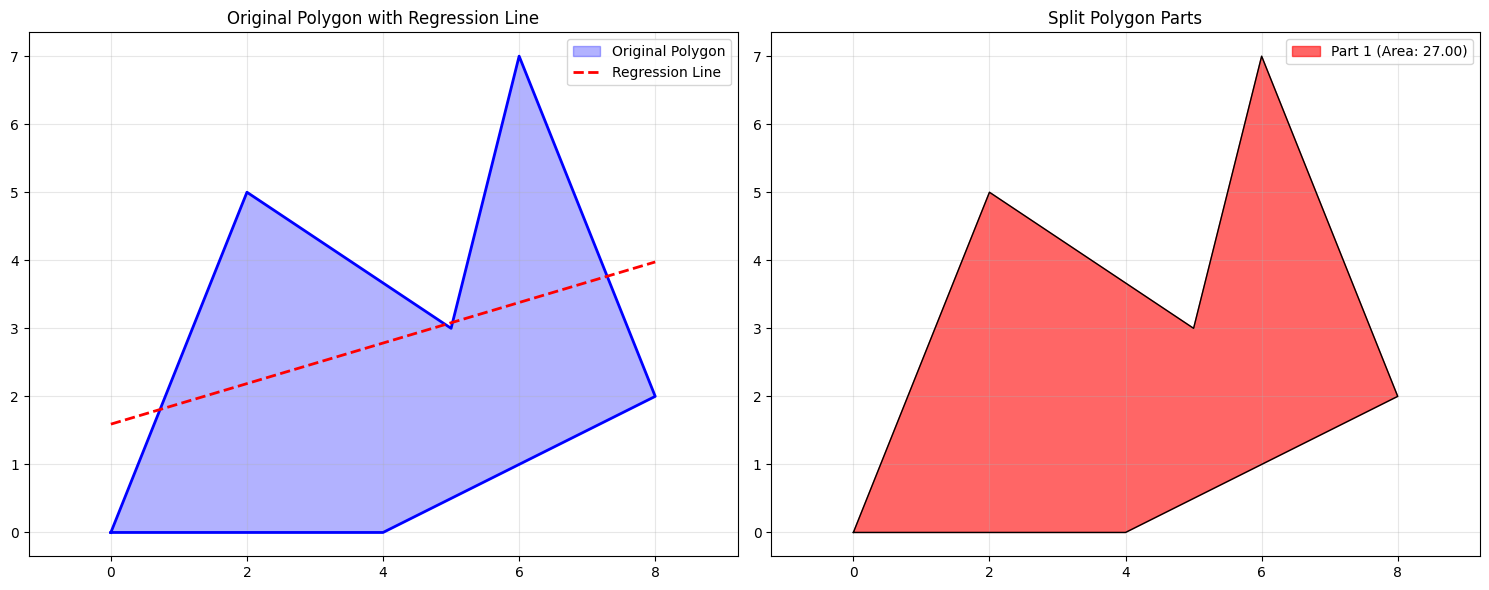

In [51]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon, LineString, Point
from shapely.ops import split
import matplotlib.pyplot as plt
from shapely.affinity import rotate, translate

def calculate_regression_line(polygon):
    """Menghitung garis regresi dari titik-titik polygon"""
    coords = np.array(polygon.exterior.coords[:-1])  # Exclude last point (duplicate)
    x, y = coords[:, 0], coords[:, 1]
    
    # Linear regression
    A = np.vstack([x, np.ones(len(x))]).T
    slope, intercept = np.linalg.lstsq(A, y, rcond=None)[0]
    
    return slope, intercept

def get_cutting_lines(polygon, slope, intercept, n):
    """Membuat garis pemotong yang pasti memotong polygon"""
    bounds = polygon.bounds
    minx, miny, maxx, maxy = bounds
    
    # Hitung angle dari slope
    angle = np.arctan(slope) if slope != float('inf') else np.pi/2
    perp_angle = angle + np.pi/2
    
    # Proyeksikan titik-titik polygon ke garis regresi untuk mendapatkan distribusi
    coords = np.array(polygon.exterior.coords[:-1])
    
    # Hitung proyeksi setiap titik ke garis regresi
    projections = []
    for x, y in coords:
        # Proyeksi titik ke garis regresi
        if slope != float('inf'):
            # Rumus proyeksi titik ke garis ax + by + c = 0
            # Garis regresi: y = mx + b -> mx - y + b = 0
            a, b, c = slope, -1, intercept
            proj_x = (b*(b*x - a*y) - a*c) / (a*a + b*b)
            proj_y = (a*(-b*x + a*y) - b*c) / (a*a + b*b)
        else:
            # Garis vertikal
            proj_x = -intercept  # x = -intercept untuk garis vertikal
            proj_y = y
        
        # Hitung jarak sepanjang garis regresi
        if slope != float('inf'):
            dist = np.sqrt((proj_x - minx)**2 + (proj_y - (slope*minx + intercept))**2)
        else:
            dist = abs(proj_y - miny)
        
        projections.append(dist)
    
    # Tentukan posisi pemotongan berdasarkan distribusi proyeksi
    min_proj, max_proj = min(projections), max(projections)
    
    lines = []
    for i in range(1, n):
        # Posisi pemotongan
        cut_pos = min_proj + (i / n) * (max_proj - min_proj)
        
        # Titik di garis regresi
        if slope != float('inf'):
            cut_x = minx + cut_pos * np.cos(angle)
            cut_y = slope * cut_x + intercept
        else:
            cut_x = -intercept
            cut_y = miny + cut_pos
        
        # Buat garis pemotong yang pasti melewati polygon
        # Extend garis dalam kedua arah sepanjang diagonal polygon
        diagonal = np.sqrt((maxx - minx)**2 + (maxy - miny)**2)
        extend = diagonal * 2  # Pastikan garis cukup panjang
        
        # Arah garis pemotong (tegak lurus dengan regresi)
        dx = extend * np.cos(perp_angle)
        dy = extend * np.sin(perp_angle)
        
        # Titik awal dan akhir garis pemotong
        x1, y1 = cut_x - dx, cut_y - dy
        x2, y2 = cut_x + dx, cut_y + dy
        
        lines.append(LineString([(x1, y1), (x2, y2)]))
    
    return lines

def split_polygon_equal_area(polygon, n):
    """Membagi polygon menjadi n bagian dengan area yang sama"""
    if not isinstance(polygon, Polygon):
        raise ValueError("Input harus Shapely Polygon")
    
    if n <= 1:
        return [polygon]
    
    target_area = polygon.area / n
    tolerance = 0.01 * target_area  # Toleransi 1%
    
    # Hitung garis regresi
    slope, intercept = calculate_regression_line(polygon)
    
    # Coba berbagai posisi pemotongan hingga mendapatkan area yang sama
    result_parts = []
    remaining_polygon = polygon
    
    for i in range(n - 1):  # n-1 pemotongan untuk n bagian
        best_line = None
        best_parts = None
        best_error = float('inf')
        
        # Coba berbagai posisi garis pemotong
        bounds = remaining_polygon.bounds
        minx, miny, maxx, maxy = bounds
        
        # Hitung angle dari slope
        angle = np.arctan(slope) if slope != float('inf') else np.pi/2
        perp_angle = angle + np.pi/2
        
        # Coba berbagai posisi sepanjang arah utama polygon
        for ratio in np.linspace(0.1, 0.9, 50):  # 50 posisi berbeda
            if slope != float('inf'):
                cut_x = minx + ratio * (maxx - minx)
                cut_y = slope * cut_x + intercept
            else:
                cut_x = -intercept
                cut_y = miny + ratio * (maxy - miny)
            
            # Buat garis pemotong
            diagonal = np.sqrt((maxx - minx)**2 + (maxy - miny)**2)
            extend = diagonal * 2
            
            dx = extend * np.cos(perp_angle)
            dy = extend * np.sin(perp_angle)
            
            x1, y1 = cut_x - dx, cut_y - dy
            x2, y2 = cut_x + dx, cut_y + dy
            
            line = LineString([(x1, y1), (x2, y2)])
            
            # Coba potong
            try:
                split_result = split(remaining_polygon, line)
                if len(split_result.geoms) >= 2:
                    parts = list(split_result.geoms)
                    # Ambil bagian terkecil sebagai kandidat
                    parts.sort(key=lambda p: p.area)
                    smallest_part = parts[0]
                    
                    # Cek apakah area mendekati target
                    error = abs(smallest_part.area - target_area)
                    if error < best_error:
                        best_error = error
                        best_line = line
                        best_parts = parts
                        
                        # Jika sudah cukup akurat, stop
                        if error < tolerance:
                            break
            except:
                continue
        
        # Gunakan hasil terbaik
        if best_parts is not None:
            best_parts.sort(key=lambda p: p.area)
            result_parts.append(best_parts[0])  # Ambil bagian terkecil
            
            # Update remaining polygon (gabungan sisa bagian)
            remaining_parts = best_parts[1:]
            if len(remaining_parts) == 1:
                remaining_polygon = remaining_parts[0]
            else:
                # Gabungkan sisa bagian
                remaining_polygon = remaining_parts[0]
                for part in remaining_parts[1:]:
                    remaining_polygon = remaining_polygon.union(part)
        else:
            # Jika tidak bisa dipotong lagi, bagi remaining polygon
            break
    
    # Tambahkan sisa polygon
    result_parts.append(remaining_polygon)
    
    return result_parts

def split_polygon_by_regression(polygon, n):
    """Membagi polygon berdasarkan garis regresi dengan area yang sama"""
    return split_polygon_equal_area(polygon, n)

# Contoh penggunaan
if __name__ == "__main__":
    # Contoh polygon tidak beraturan
    poly = Polygon([(0,0), (2,5), (5,3), (6,7), (8,2), (4,0), (0,0)])
    
    # Split menjadi 3 bagian
    parts = split_polygon_by_regression(poly, 3)
    
    print(f"Original area: {poly.area:.2f}")
    print(f"Number of parts: {len(parts)}")
    for i, part in enumerate(parts):
        print(f"Part {i+1} area: {part.area:.2f}")
    
    # Visualisasi
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Original polygon
    x, y = poly.exterior.xy
    ax1.fill(x, y, alpha=0.3, color='blue', label='Original Polygon')
    ax1.plot(x, y, 'b-', linewidth=2)
    
    # Plot garis regresi
    slope, intercept = calculate_regression_line(poly)
    bounds = poly.bounds
    if slope != float('inf'):
        x_vals = np.array([bounds[0], bounds[2]])
        y_vals = slope * x_vals + intercept
        ax1.plot(x_vals, y_vals, 'r--', linewidth=2, label='Regression Line')
    
    ax1.set_title('Original Polygon with Regression Line')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.axis('equal')
    
    # Plot 2: Split polygon
    colors = ['red', 'green', 'orange', 'purple', 'brown']
    for i, part in enumerate(parts):
        x, y = part.exterior.xy
        color = colors[i % len(colors)]
        ax2.fill(x, y, alpha=0.6, color=color, label=f'Part {i+1} (Area: {part.area:.2f})')
        ax2.plot(x, y, color='black', linewidth=1)
    
    ax2.set_title('Split Polygon Parts')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.axis('equal')
    
    plt.tight_layout()
    plt.show()

=== PROGRAM PEMBAGIAN POLYGON ===
1. Gunakan data contoh
2. Input data polygon sendiri


Menggunakan data polygon contoh...
Masukkan angka yang valid!
Masukkan angka yang valid!
Masukkan angka yang valid!
Masukkan angka yang valid!

Membuat visualisasi dengan 5 bagian...
Berhasil membuat 4 garis pembagi!
Garis pembagi tegak lurus terhadap garis regresi dan membagi polygon menjadi bagian dengan luas yang sama.


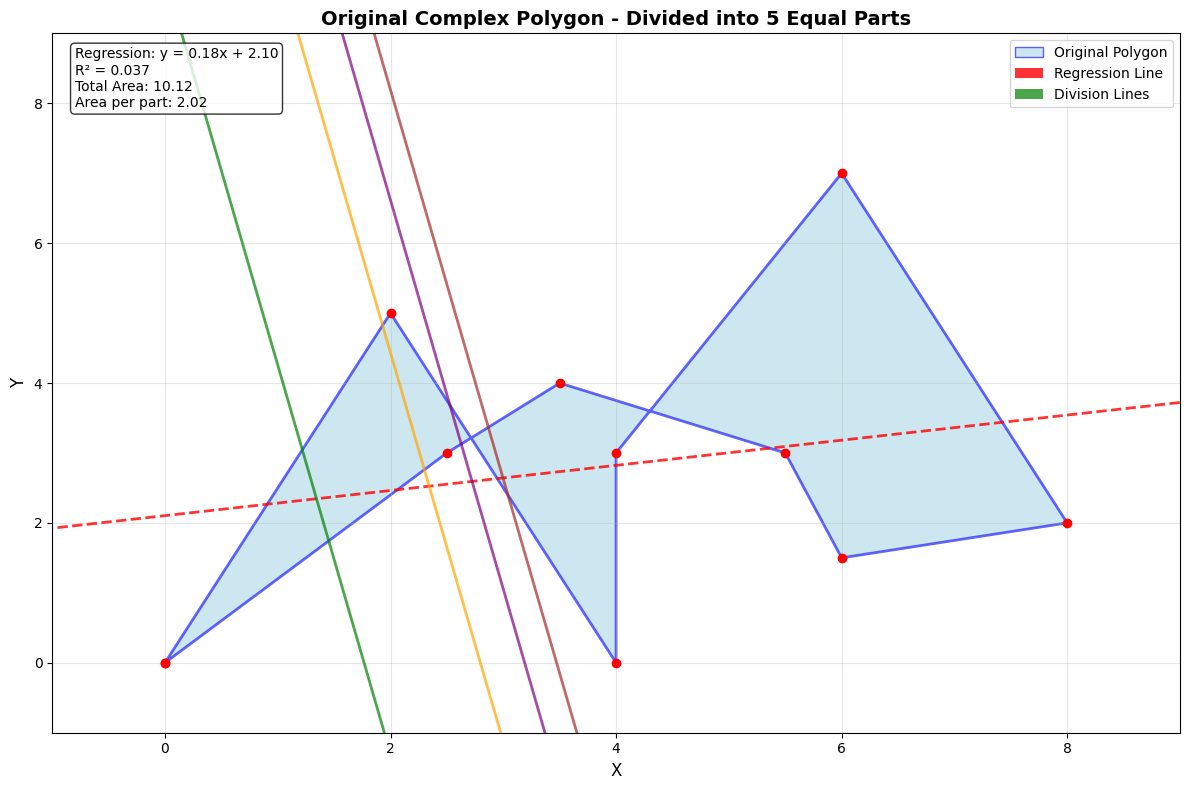

In [57]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Polygon
from sklearn.linear_model import LinearRegression
import matplotlib.patches as mpatches
from shapely.geometry import Polygon as ShapelyPolygon, LineString
from shapely.ops import split
import warnings
warnings.filterwarnings('ignore')

# Contoh data polygon (Anda bisa mengganti dengan data Anda sendiri)
polygon_data = [
    (0, 0),
    (2, 5),
    (4, 0),
    (4, 3),
    (6, 7),
    (8, 2),
    (6, 1.5),
    (5.5, 3),
    (3.5, 4),
    (2.5, 3),
    (0, 0)  # Kembali ke titik awal untuk menutup polygon
]

def calculate_polygon_area(points):
    """Menghitung luas polygon menggunakan shoelace formula"""
    n = len(points)
    area = 0.0
    for i in range(n):
        j = (i + 1) % n
        area += points[i][0] * points[j][1]
        area -= points[j][0] * points[i][1]
    return abs(area) / 2.0

def line_polygon_intersection(line_slope, line_intercept, polygon_points):
    """Mencari titik potong antara garis dan polygon"""
    intersections = []
    n = len(polygon_points)
    
    for i in range(n):
        p1 = polygon_points[i]
        p2 = polygon_points[(i + 1) % n]
        
        # Hindari pembagian dengan nol
        if abs(p2[0] - p1[0]) < 1e-10:  # Garis vertikal
            x = p1[0]
            y = line_slope * x + line_intercept
            if min(p1[1], p2[1]) <= y <= max(p1[1], p2[1]):
                intersections.append((x, y))
        else:
            # Slope dari edge polygon
            edge_slope = (p2[1] - p1[1]) / (p2[0] - p1[0])
            edge_intercept = p1[1] - edge_slope * p1[0]
            
            # Cari titik potong
            if abs(line_slope - edge_slope) > 1e-10:  # Garis tidak sejajar
                x = (edge_intercept - line_intercept) / (line_slope - edge_slope)
                y = line_slope * x + line_intercept
                
                # Cek apakah titik potong berada dalam segment
                if (min(p1[0], p2[0]) <= x <= max(p1[0], p2[0]) and 
                    min(p1[1], p2[1]) <= y <= max(p1[1], p2[1])):
                    intersections.append((x, y))
    
    # Hapus duplikat
    unique_intersections = []
    for point in intersections:
        is_duplicate = False
        for existing in unique_intersections:
            if abs(point[0] - existing[0]) < 1e-6 and abs(point[1] - existing[1]) < 1e-6:
                is_duplicate = True
                break
        if not is_duplicate:
            unique_intersections.append(point)
    
    return unique_intersections

def find_division_lines(polygon_points, regression_slope, regression_intercept, num_parts):
    """
    Mencari garis-garis pembagi yang tegak lurus regresi untuk membagi polygon 
    menjadi bagian dengan luas yang sama
    """
    # Slope garis tegak lurus
    if abs(regression_slope) < 1e-10:  # Garis regresi horizontal
        perp_slope = float('inf')  # Garis vertikal
    else:
        perp_slope = -1 / regression_slope
    
    # Hitung total luas
    total_area = calculate_polygon_area(polygon_points)
    target_area_per_part = total_area / num_parts
    
    # Cari batas x minimum dan maksimum
    x_coords = [p[0] for p in polygon_points]
    x_min, x_max = min(x_coords), max(x_coords)
    
    division_lines = []
    current_area = 0
    
    for part in range(num_parts - 1):  # n-1 garis untuk n bagian
        target_cumulative_area = (part + 1) * target_area_per_part
        
        # Binary search untuk mencari posisi garis yang tepat
        left_x = x_min
        right_x = x_max
        
        for iteration in range(50):  # Maksimal 50 iterasi
            mid_x = (left_x + right_x) / 2
            
            # Buat garis vertikal atau dengan slope tegak lurus
            if perp_slope == float('inf'):  # Garis vertikal
                test_line_points = [(mid_x, -1000), (mid_x, 1000)]
            else:
                test_intercept = -perp_slope * mid_x  # Garis melewati (mid_x, 0) dengan slope tegak lurus
                test_line_points = [(x_min - 10, perp_slope * (x_min - 10) + test_intercept),
                                   (x_max + 10, perp_slope * (x_max + 10) + test_intercept)]
            
            # Hitung luas bagian kiri dari garis
            left_area = calculate_left_area(polygon_points, test_line_points, mid_x)
            
            if abs(left_area - target_cumulative_area) < total_area * 0.001:  # Toleransi 0.1%
                if perp_slope == float('inf'):
                    division_lines.append(('vertical', mid_x))
                else:
                    test_intercept = -perp_slope * mid_x
                    division_lines.append(('sloped', perp_slope, test_intercept, mid_x))
                break
            elif left_area < target_cumulative_area:
                left_x = mid_x
            else:
                right_x = mid_x
    
    return division_lines

def calculate_left_area(polygon_points, line_points, x_threshold):
    """Menghitung luas bagian polygon di sebelah kiri garis vertikal"""
    # Implementasi sederhana untuk garis vertikal
    left_points = []
    
    # Tambahkan titik-titik polygon yang berada di sebelah kiri
    for point in polygon_points:
        if point[0] <= x_threshold:
            left_points.append(point)
    
    # Tambahkan titik potong dengan polygon
    n = len(polygon_points)
    for i in range(n):
        p1 = polygon_points[i]
        p2 = polygon_points[(i + 1) % n]
        
        # Cek apakah edge melintasi garis vertikal
        if (p1[0] <= x_threshold <= p2[0]) or (p2[0] <= x_threshold <= p1[0]):
            if abs(p2[0] - p1[0]) > 1e-10:  # Bukan garis vertikal
                # Interpolasi untuk mencari titik potong
                t = (x_threshold - p1[0]) / (p2[0] - p1[0])
                y_intersect = p1[1] + t * (p2[1] - p1[1])
                left_points.append((x_threshold, y_intersect))
    
    if len(left_points) < 3:
        return 0
    
    # Urutkan titik-titik untuk membentuk polygon yang valid
    # Implementasi sederhana: urutkan berdasarkan sudut dari centroid
    if left_points:
        # Cari centroid
        cx = sum(p[0] for p in left_points) / len(left_points)
        cy = sum(p[1] for p in left_points) / len(left_points)
        
        # Urutkan berdasarkan sudut
        def angle_from_center(point):
            return np.arctan2(point[1] - cy, point[0] - cx)
        
        left_points.sort(key=angle_from_center)
        return calculate_polygon_area(left_points)
    
    return 0

def create_polygon_with_division(polygon_points, num_parts=3, figsize=(12, 8)):
    """
    Membuat visualisasi polygon kompleks dengan garis regresi dan pembagian
    
    Parameters:
    polygon_points: list of tuples [(x1, y1), (x2, y2), ...]
    num_parts: jumlah bagian yang diinginkan
    figsize: tuple untuk ukuran figure
    """
    
    # Konversi ke numpy array
    points = np.array(polygon_points)
    x_coords = points[:, 0]
    y_coords = points[:, 1]
    
    # Hilangkan titik duplikat terakhir jika ada (untuk regresi)
    if len(points) > 1 and np.array_equal(points[0], points[-1]):
        x_reg = x_coords[:-1]
        y_reg = y_coords[:-1]
    else:
        x_reg = x_coords
        y_reg = y_coords
    
    # Hitung garis regresi linear
    X = x_reg.reshape(-1, 1)
    y = y_reg
    
    reg_model = LinearRegression()
    reg_model.fit(X, y)
    regression_slope = reg_model.coef_[0]
    regression_intercept = reg_model.intercept_
    
    # Cari garis-garis pembagi
    division_lines = find_division_lines(polygon_points, regression_slope, regression_intercept, num_parts)
    
    # Buat plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Gambar polygon dengan fill
    polygon_patch = Polygon(polygon_points, 
                           facecolor='lightblue', 
                           edgecolor='blue', 
                           linewidth=2, 
                           alpha=0.6)
    ax.add_patch(polygon_patch)
    
    # Gambar titik-titik vertex
    ax.plot(x_coords, y_coords, 'ro', markersize=6, zorder=5)
    
    # Gambar garis regresi
    x_range = np.linspace(x_coords.min() - 2, x_coords.max() + 2, 100)
    y_pred = reg_model.predict(x_range.reshape(-1, 1))
    ax.plot(x_range, y_pred, 'r--', linewidth=2, alpha=0.8)
    
    # Gambar garis-garis pembagi (tegak lurus regresi)
    colors = ['green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    y_min = min(y_coords) - 1
    y_max = max(y_coords) + 2
    
    for i, line_info in enumerate(division_lines):
        color = colors[i % len(colors)]
        
        if line_info[0] == 'vertical':
            x_div = line_info[1]
            ax.axvline(x=x_div, color=color, linestyle='-', linewidth=2, alpha=0.7)
        else:
            # Garis dengan slope
            _, perp_slope, perp_intercept, x_center = line_info
            x_line = np.linspace(x_coords.min() - 1, x_coords.max() + 1, 100)
            y_line = perp_slope * x_line + perp_intercept
            ax.plot(x_line, y_line, color=color, linestyle='-', linewidth=2, alpha=0.7)
    
    # Customisasi plot
    ax.set_xlim(x_coords.min() - 1, x_coords.max() + 1)
    ax.set_ylim(y_min, y_max)
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    ax.set_title(f'Original Complex Polygon - Divided into {num_parts} Equal Parts', 
                 fontsize=14, fontweight='bold')
    
    # Legenda
    polygon_legend = mpatches.Rectangle((0, 0), 1, 1, 
                                       facecolor='lightblue', 
                                       edgecolor='blue', 
                                       alpha=0.6)
    regression_legend = mpatches.Rectangle((0, 0), 1, 1, 
                                         facecolor='red', 
                                         linestyle='--',
                                         alpha=0.8)
    division_legend = mpatches.Rectangle((0, 0), 1, 1, 
                                       facecolor='green', 
                                       alpha=0.7)
    
    ax.legend([polygon_legend, regression_legend, division_legend], 
              ['Original Polygon', 'Regression Line', 'Division Lines'], 
              loc='upper right')
    
    # Tampilkan informasi
    slope = reg_model.coef_[0]
    intercept = reg_model.intercept_
    r_squared = reg_model.score(X, y)
    total_area = calculate_polygon_area(polygon_points)
    area_per_part = total_area / num_parts
    
    info_text = f'Regression: y = {slope:.2f}x + {intercept:.2f}\n'
    info_text += f'R² = {r_squared:.3f}\n'
    info_text += f'Total Area: {total_area:.2f}\n'
    info_text += f'Area per part: {area_per_part:.2f}'
    
    ax.text(0.02, 0.98, info_text, transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    return fig, ax, reg_model, division_lines

# Fungsi untuk input data polygon custom
def input_polygon_data():
    """Fungsi untuk input data polygon secara interaktif"""
    print("Masukkan koordinat polygon (x, y):")
    print("Ketik 'selesai' untuk mengakhiri input")
    
    points = []
    i = 1
    while True:
        try:
            user_input = input(f"Titik {i} (x, y) atau 'selesai': ").strip()
            if user_input.lower() == 'selesai':
                break
            
            # Parse input
            coords = user_input.replace('(', '').replace(')', '').split(',')
            x = float(coords[0].strip())
            y = float(coords[1].strip())
            points.append((x, y))
            i += 1
            
        except (ValueError, IndexError):
            print("Format salah! Gunakan format: x, y (contoh: 1, 2)")
            continue
    
    return points

def input_num_parts():
    """Input jumlah bagian pembagian"""
    while True:
        try:
            num_parts = int(input("Masukkan jumlah bagian yang diinginkan: "))
            if num_parts < 2:
                print("Jumlah bagian minimal adalah 2!")
                continue
            return num_parts
        except ValueError:
            print("Masukkan angka yang valid!")

# Contoh penggunaan
if __name__ == "__main__":
    print("=== PROGRAM PEMBAGIAN POLYGON ===")
    print("1. Gunakan data contoh")
    print("2. Input data polygon sendiri")
    
    choice = input("Pilih opsi (1/2): ").strip()
    
    if choice == "2":
        print("\nInput data polygon:")
        polygon_points = input_polygon_data()
        if len(polygon_points) < 3:
            print("Polygon minimal harus memiliki 3 titik!")
            polygon_points = polygon_data
    else:
        polygon_points = polygon_data
        print("Menggunakan data polygon contoh...")
    
    # Input jumlah pembagian
    num_parts = input_num_parts()
    
    # Buat visualisasi
    print(f"\nMembuat visualisasi dengan {num_parts} bagian...")
    fig, ax, model, division_lines = create_polygon_with_division(polygon_points, num_parts)
    
    print(f"Berhasil membuat {len(division_lines)} garis pembagi!")
    print("Garis pembagi tegak lurus terhadap garis regresi dan membagi polygon menjadi bagian dengan luas yang sama.")
    
    plt.show()

=== PROGRAM PEMBAGIAN POLYGON SEDERHANA ===
1. Gunakan data contoh
2. Input koordinat sendiri

Masukkan koordinat polygon:
Format: x,y (contoh: 1,2)
Ketik 'selesai' untuk mengakhiri
Format salah! Gunakan: x,y

Memproses pembagian menjadi 4 bagian...

Hasil: 4 polygon terpisah
Total area: 1.00
Polygon 1: Area = 0.25
Polygon 2: Area = 0.00
Polygon 3: Area = 0.00
Polygon 4: Area = 0.75


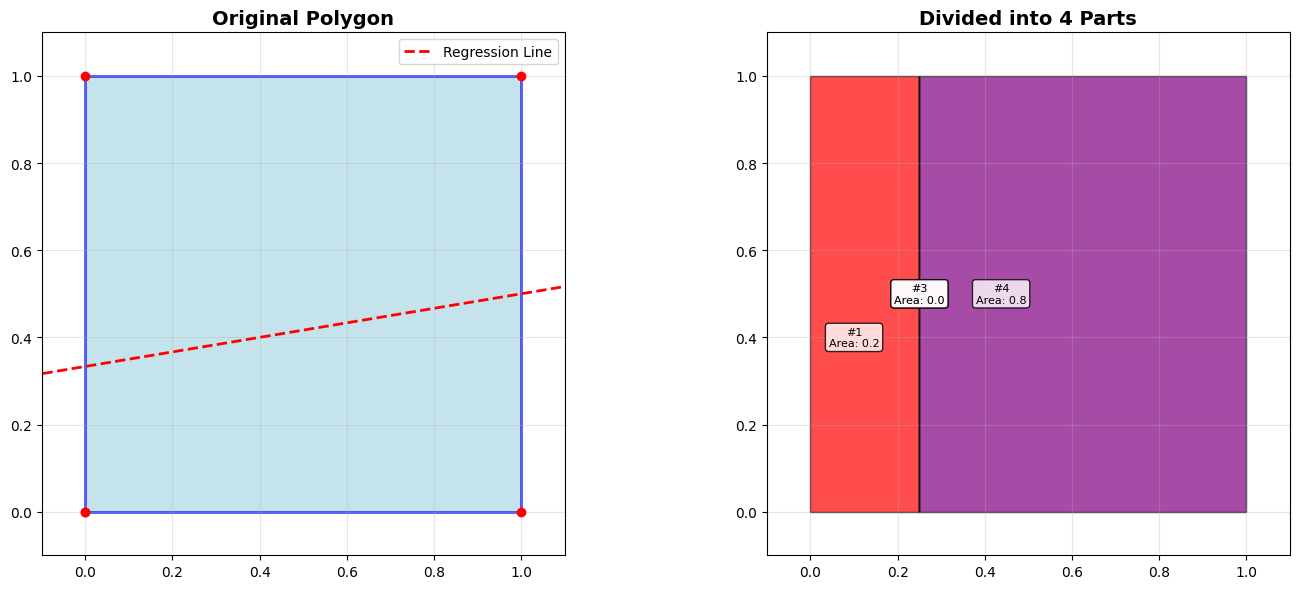


HASIL AKHIR - POLYGON TERPISAH:

Polygon 1:
Koordinat: [(0.0, 0.0), (0.0, 0.0), (0.25, 0.0), (0.25, 1.0), (0.0, 1.0)]
Area: 0.25
Jumlah titik: 5

Polygon 2:
Koordinat: [(0.25, 0.0), (0.25, 0.0), (0.25, 1.0), (0.25, 1.0)]
Area: 0.00
Jumlah titik: 4

Polygon 3:
Koordinat: [(0.25, 0.0), (0.25, 0.0), (0.25, 0.0), (0.25, 1.0), (0.25, 1.0), (0.25, 1.0)]
Area: 0.00
Jumlah titik: 6

Polygon 4:
Koordinat: [(0.25, 0.0), (0.25, 0.0), (0.25, 0.0), (1.0, 0.0), (1.0, 1.0), (0.25, 1.0), (0.25, 1.0), (0.25, 1.0)]
Area: 0.75
Jumlah titik: 8


In [59]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Polygon as MplPolygon
from sklearn.linear_model import LinearRegression
import random

def polygon_area(points):
    """Hitung luas polygon dengan shoelace formula"""
    n = len(points)
    area = 0.0
    for i in range(n):
        j = (i + 1) % n
        area += points[i][0] * points[j][1]
        area -= points[j][0] * points[i][1]
    return abs(area) / 2.0

def point_in_polygon(point, polygon):
    """Cek apakah titik berada di dalam polygon"""
    x, y = point
    n = len(polygon)
    inside = False
    
    p1x, p1y = polygon[0]
    for i in range(1, n + 1):
        p2x, p2y = polygon[i % n]
        if y > min(p1y, p2y):
            if y <= max(p1y, p2y):
                if x <= max(p1x, p2x):
                    if p1y != p2y:
                        xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                    if p1x == p2x or x <= xinters:
                        inside = not inside
        p1x, p1y = p2x, p2y
    
    return inside

def line_intersect_polygon(x_line, polygon):
    """Cari titik potong garis vertikal dengan polygon"""
    intersections = []
    n = len(polygon)
    
    for i in range(n):
        p1 = polygon[i]
        p2 = polygon[(i + 1) % n]
        
        # Cek apakah edge melintasi garis vertikal
        if (p1[0] <= x_line <= p2[0]) or (p2[0] <= x_line <= p1[0]):
            if abs(p2[0] - p1[0]) > 1e-10:
                # Hitung y intersection
                t = (x_line - p1[0]) / (p2[0] - p1[0])
                y_intersect = p1[1] + t * (p2[1] - p1[1])
                intersections.append((x_line, y_intersect))
    
    return intersections

def split_polygon_at_x(polygon, x_line):
    """Pisahkan polygon dengan garis vertikal di x = x_line"""
    intersections = line_intersect_polygon(x_line, polygon)
    
    if len(intersections) < 2:
        return [polygon], []  # Tidak bisa dipotong
    
    # Urutkan intersection berdasarkan y
    intersections.sort(key=lambda p: p[1])
    
    left_points = []
    right_points = []
    
    # Tambahkan titik-titik polygon
    for point in polygon:
        if point[0] < x_line:
            left_points.append(point)
        elif point[0] > x_line:
            right_points.append(point)
        else:  # Titik tepat di garis
            left_points.append(point)
            right_points.append(point)
    
    # Tambahkan intersection points
    for intersection in intersections:
        left_points.append(intersection)
        right_points.append(intersection)
    
    # Urutkan titik berdasarkan sudut dari centroid
    def sort_points(points):
        if len(points) < 3:
            return points
        cx = sum(p[0] for p in points) / len(points)
        cy = sum(p[1] for p in points) / len(points)
        return sorted(points, key=lambda p: np.arctan2(p[1] - cy, p[0] - cx))
    
    left_sorted = sort_points(left_points)
    right_sorted = sort_points(right_points)
    
    return left_sorted, right_sorted

def divide_polygon(polygon, num_parts):
    """Bagi polygon menjadi num_parts bagian dengan luas sama"""
    if num_parts <= 1:
        return [polygon]
    
    # Hitung total luas
    total_area = polygon_area(polygon)
    target_area = total_area / num_parts
    
    # Cari batas x
    x_coords = [p[0] for p in polygon]
    x_min, x_max = min(x_coords), max(x_coords)
    
    # Cari posisi pembagian dengan binary search
    division_x_positions = []
    current_polygon = polygon
    
    for part in range(num_parts - 1):
        target_cumulative_area = (part + 1) * target_area
        
        # Binary search untuk posisi x yang tepat
        left_x = x_min
        right_x = x_max
        
        for _ in range(50):  # Max 50 iterasi
            mid_x = (left_x + right_x) / 2
            
            # Hitung luas bagian kiri
            left_poly, _ = split_polygon_at_x(current_polygon, mid_x)
            if len(left_poly) >= 3:
                left_area = polygon_area(left_poly)
            else:
                left_area = 0
            
            if abs(left_area - target_area) < total_area * 0.001:
                division_x_positions.append(mid_x)
                break
            elif left_area < target_area:
                left_x = mid_x
            else:
                right_x = mid_x
    
    # Pisahkan polygon secara bertahap
    result_polygons = []
    remaining_polygon = polygon
    
    for x_pos in division_x_positions:
        left_poly, right_poly = split_polygon_at_x(remaining_polygon, x_pos)
        if len(left_poly) >= 3:
            result_polygons.append(left_poly)
        remaining_polygon = right_poly
    
    # Tambahkan sisa polygon
    if len(remaining_polygon) >= 3:
        result_polygons.append(remaining_polygon)
    
    return result_polygons

def visualize_divided_polygons(original_polygon, divided_polygons, show_regression=True):
    """Visualisasi polygon yang sudah terbagi"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Original dengan garis regresi
    points = np.array(original_polygon)
    x_coords = points[:, 0]
    y_coords = points[:, 1]
    
    # Gambar polygon original
    original_patch = MplPolygon(original_polygon, 
                               facecolor='lightblue', 
                               edgecolor='blue', 
                               linewidth=2, 
                               alpha=0.7)
    ax1.add_patch(original_patch)
    
    if show_regression:
        # Hitung dan gambar garis regresi
        X = x_coords.reshape(-1, 1)
        y = y_coords
        reg_model = LinearRegression()
        reg_model.fit(X, y)
        
        x_range = np.linspace(x_coords.min() - 1, x_coords.max() + 1, 100)
        y_pred = reg_model.predict(x_range.reshape(-1, 1))
        ax1.plot(x_range, y_pred, 'r--', linewidth=2, label='Regression Line')
    
    ax1.plot(x_coords, y_coords, 'ro', markersize=6)
    ax1.set_title('Original Polygon', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot 2: Polygon terbagi
    colors = ['red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    
    for i, poly in enumerate(divided_polygons):
        if len(poly) >= 3:
            color = colors[i % len(colors)]
            poly_patch = MplPolygon(poly, 
                                   facecolor=color, 
                                   edgecolor='black', 
                                   linewidth=1, 
                                   alpha=0.7)
            ax2.add_patch(poly_patch)
            
            # Tambahkan label area
            poly_points = np.array(poly)
            cx = np.mean(poly_points[:, 0])
            cy = np.mean(poly_points[:, 1])
            area = polygon_area(poly)
            ax2.text(cx, cy, f'#{i+1}\nArea: {area:.1f}', 
                    ha='center', va='center', fontsize=8, 
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    ax2.set_title(f'Divided into {len(divided_polygons)} Parts', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Set limits yang sama
    all_x = [p[0] for poly in [original_polygon] + divided_polygons for p in poly]
    all_y = [p[1] for poly in [original_polygon] + divided_polygons for p in poly]
    
    x_margin = (max(all_x) - min(all_x)) * 0.1
    y_margin = (max(all_y) - min(all_y)) * 0.1
    
    for ax in [ax1, ax2]:
        ax.set_xlim(min(all_x) - x_margin, max(all_x) + x_margin)
        ax.set_ylim(min(all_y) - y_margin, max(all_y) + y_margin)
        ax.set_aspect('equal')
    
    plt.tight_layout()
    return fig

def main():
    """Fungsi utama program"""
    
    # Data polygon contoh
    polygon_data = [
        (0, 0), (2, 5), (4, 0), (4, 3), 
        (6, 7), (8, 2), (6, 1.5), (5.5, 3), 
        (3.5, 4), (2.5, 3), (0, 0)
    ]
    
    print("=== PROGRAM PEMBAGIAN POLYGON SEDERHANA ===")
    print("1. Gunakan data contoh")
    print("2. Input koordinat sendiri")
    
    choice = input("Pilih (1/2): ").strip()
    
    if choice == "2":
        print("\nMasukkan koordinat polygon:")
        print("Format: x,y (contoh: 1,2)")
        print("Ketik 'selesai' untuk mengakhiri")
        
        points = []
        while True:
            inp = input(f"Titik {len(points)+1}: ").strip()
            if inp.lower() == 'selesai':
                break
            try:
                x, y = map(float, inp.split(','))
                points.append((x, y))
            except:
                print("Format salah! Gunakan: x,y")
        
        if len(points) >= 3:
            # Tutup polygon
            if points[0] != points[-1]:
                points.append(points[0])
            polygon_data = points
        else:
            print("Minimal 3 titik! Menggunakan data contoh.")
    
    # Input jumlah bagian
    while True:
        try:
            num_parts = int(input("Jumlah bagian: "))
            if num_parts >= 2:
                break
            print("Minimal 2 bagian!")
        except:
            print("Masukkan angka!")
    
    # Proses pembagian
    print(f"\nMemproses pembagian menjadi {num_parts} bagian...")
    
    divided_polygons = divide_polygon(polygon_data, num_parts)
    
    # Tampilkan hasil
    print(f"\nHasil: {len(divided_polygons)} polygon terpisah")
    total_area = polygon_area(polygon_data)
    print(f"Total area: {total_area:.2f}")
    
    for i, poly in enumerate(divided_polygons):
        area = polygon_area(poly)
        print(f"Polygon {i+1}: Area = {area:.2f}")
    
    # Visualisasi
    fig = visualize_divided_polygons(polygon_data, divided_polygons)
    plt.show()
    
    # Return hasil untuk penggunaan lebih lanjut
    return divided_polygons

# Fungsi untuk akses mudah hasil pembagian
def split_polygon_simple(polygon_points, num_parts):
    """
    Fungsi sederhana untuk membagi polygon
    
    Args:
        polygon_points: list of (x, y) tuples
        num_parts: int, jumlah bagian
        
    Returns:
        list of polygons, masing-masing adalah list of (x, y) tuples
    """
    return divide_polygon(polygon_points, num_parts)

if __name__ == "__main__":
    # Jalankan program utama
    result_polygons = main()
    
    print("\n" + "="*50)
    print("HASIL AKHIR - POLYGON TERPISAH:")
    print("="*50)
    
    for i, poly in enumerate(result_polygons):
        print(f"\nPolygon {i+1}:")
        print("Koordinat:", poly)
        print(f"Area: {polygon_area(poly):.2f}")
        print(f"Jumlah titik: {len(poly)}")

=== POLYGON DIVIDER ===

Found 2 polygons:
1. Area: 0.00
2. Area: 0.00
Polygon area: 0.00
Polygon bounds: (110.49484962623309, -7.951892917694229, 110.5202176132861, -7.937054465937138)

Dividing polygon into 4 parts...

Result: 1 polygons
Part 1: Area = 0.00 (100.0%)
Total area check: 0.00 (original: 0.00)


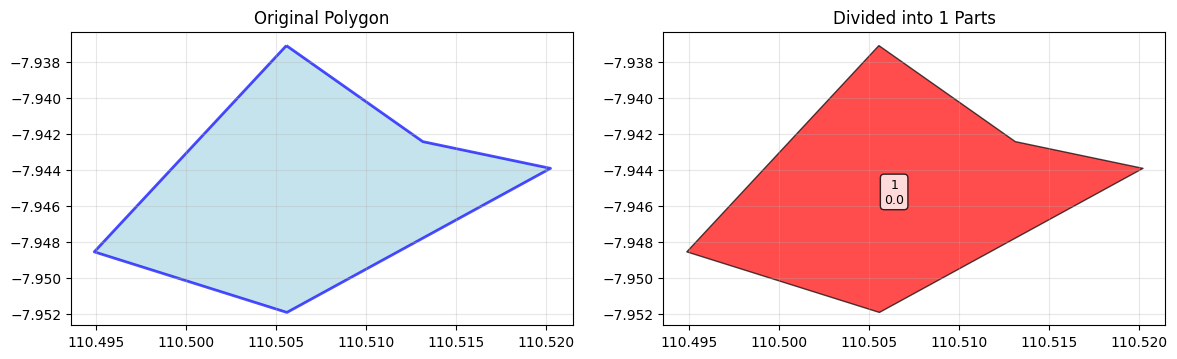

In [62]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon, LineString
from shapely.ops import split
import warnings
warnings.filterwarnings('ignore')

def divide_polygon_equal_area(polygon, num_parts):
    """Bagi polygon menjadi num_parts bagian dengan luas yang hampir sama"""
    if num_parts <= 1:
        return [polygon]
    
    total_area = polygon.area
    target_area = total_area / num_parts
    
    # Tentukan batas x
    bounds = polygon.bounds
    x_min, x_max = bounds[0], bounds[2]
    
    # Cari posisi pembagian
    result_polygons = []
    current_polygon = polygon
    
    for part in range(num_parts - 1):
        # Binary search untuk posisi x yang tepat
        left_x = x_min
        right_x = x_max
        
        for _ in range(30):  # Maksimal 30 iterasi
            mid_x = (left_x + right_x) / 2
            
            # Buat garis vertikal untuk memotong
            line = LineString([(mid_x, bounds[1] - 1), (mid_x, bounds[3] + 1)])
            
            try:
                # Split polygon dengan garis
                split_result = split(current_polygon, line)
                
                if len(split_result.geoms) >= 2:
                    # Ambil bagian kiri (polygon dengan x terkecil)
                    left_parts = []
                    right_parts = []
                    
                    for geom in split_result.geoms:
                        if geom.centroid.x < mid_x:
                            left_parts.append(geom)
                        else:
                            right_parts.append(geom)
                    
                    if left_parts:
                        # Gabungkan semua bagian kiri
                        from shapely.ops import unary_union
                        left_polygon = unary_union(left_parts)
                        
                        left_area = left_polygon.area
                        
                        if abs(left_area - target_area) < total_area * 0.01:  # Toleransi 1%
                            result_polygons.append(left_polygon)
                            current_polygon = unary_union(right_parts) if right_parts else current_polygon
                            break
                        elif left_area < target_area:
                            left_x = mid_x
                        else:
                            right_x = mid_x
                    else:
                        left_x = mid_x
                else:
                    left_x = mid_x
                    
            except Exception:
                left_x = mid_x
    
    # Tambahkan sisa polygon
    if current_polygon.area > 0:
        result_polygons.append(current_polygon)
    
    return result_polygons

def visualize_polygons(original_polygon, divided_polygons):
    """Visualisasi polygon yang sudah terbagi"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot original polygon
    gpd.GeoSeries([original_polygon]).plot(ax=ax1, color='lightblue', edgecolor='blue', linewidth=2, alpha=0.7)
    ax1.set_title('Original Polygon')
    ax1.grid(True, alpha=0.3)
    ax1.set_aspect('equal')
    
    # Plot divided polygons
    colors = ['red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive']
    
    for i, poly in enumerate(divided_polygons):
        color = colors[i % len(colors)]
        gpd.GeoSeries([poly]).plot(ax=ax2, color=color, edgecolor='black', 
                                  linewidth=1, alpha=0.7)
        
        # Label area
        centroid = poly.centroid
        area = poly.area
        ax2.text(centroid.x, centroid.y, f'{i+1}\n{area:.1f}', 
                ha='center', va='center', fontsize=9, 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax2.set_title(f'Divided into {len(divided_polygons)} Parts')
    ax2.grid(True, alpha=0.3)
    ax2.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()

def main():
    print("=== POLYGON DIVIDER ===")
    
    # Input file GeoJSON
    file_path = "testes.geojson"
    
    try:
        # Baca file dengan geopandas
        gdf = gpd.read_file(file_path)
        
        # Ambil polygon pertama
        if len(gdf) == 0:
            print("No polygons found in file!")
            return
        
        # Jika ada multiple polygons, tampilkan pilihan
        if len(gdf) > 1:
            print(f"\nFound {len(gdf)} polygons:")
            for i, row in gdf.iterrows():
                area = row.geometry.area
                print(f"{i+1}. Area: {area:.2f}")
            
            choice = int(input(f"Choose polygon (1-{len(gdf)}): ")) - 1
            polygon = gdf.iloc[choice].geometry
        else:
            polygon = gdf.iloc[0].geometry
        
        print(f"Polygon area: {polygon.area:.2f}")
        print(f"Polygon bounds: {polygon.bounds}")
        
        # Input jumlah bagian
        num_parts = int(input("Number of parts to divide: "))
        
        # Proses pembagian
        print(f"\nDividing polygon into {num_parts} parts...")
        divided = divide_polygon_equal_area(polygon, num_parts)
        
        # Tampilkan hasil
        print(f"\nResult: {len(divided)} polygons")
        total_area = sum(poly.area for poly in divided)
        
        for i, poly in enumerate(divided):
            percentage = (poly.area / total_area) * 100
            print(f"Part {i+1}: Area = {poly.area:.2f} ({percentage:.1f}%)")
        
        print(f"Total area check: {total_area:.2f} (original: {polygon.area:.2f})")
        
        # Visualisasi
        visualize_polygons(polygon, divided)
        
    except Exception as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    main()

In [72]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString, MultiPolygon
from shapely.ops import split
import numpy as np

# Polygon utama (ganti dengan input lain kalau mau)
polygon = Polygon([(0, 0), (2, 5), (4, 0), (5, 3), (6, 7), (8, 2), (0, 0)])

# Ambil koordinat untuk regresi linear
coords = np.array(polygon.exterior.coords)
X = coords[:, 0]
Y = coords[:, 1]
a, b = np.polyfit(X, Y, 1)  # y = ax + b

# Fungsi regresi dan vektor tegak lurus
regression = lambda x: a * x + b
normal = np.array([-a, 1]) / np.linalg.norm([-a, 1])
tangent = np.array([1, a]) / np.linalg.norm([1, a])

# Proyeksikan polygon ke sumbu regresi untuk estimasi panjang
centroid = polygon.centroid
n = 5  # jumlah pembagian
line_length = 10000

# Fungsi untuk membuat garis pemotong pada posisi t sepanjang regresi
def make_cutter(t_center):
    center = centroid.coords[0] + tangent * t_center
    dx, dy = normal
    p1 = (center[0] - dx * line_length, center[1] - dy * line_length)
    p2 = (center[0] + dx * line_length, center[1] + dy * line_length)
    return LineString([p1, p2])

# Estimasi panjang total sepanjang sumbu regresi
projected = lambda p: np.dot(np.array(p) - centroid.coords[0], tangent)
min_proj = min([projected(p) for p in polygon.exterior.coords])
max_proj = max([projected(p) for p in polygon.exterior.coords])
total_length = max_proj - min_proj

# Cari batas potong dengan iterasi sampai luas seimbang
target_area = polygon.area / n
cutters = []
parts = [polygon]
t_values = []

for i in range(1, n):
    low = min_proj
    high = max_proj
    best_t = None
    for _ in range(30):  # binary search
        mid = (low + high) / 2
        cutter = make_cutter(mid)
        temp = list(split(parts[-1], cutter))
        geoms = [g for g in temp.geoms if g.geom_type == 'Polygon']
        if len(geoms) < 2:
            low = mid
            continue
        left, right = sorted(geoms, key=lambda g: projected(g.centroid.coords[0]))
        if left.area < target_area:
            low = mid
        else:
            high = mid
            best_t = mid
    if best_t:
        t_values.append(best_t)
        cutter = make_cutter(best_t)
        last_poly = parts.pop()
        result = split(last_poly, cutter)
        geoms = [g for g in result.geoms if g.geom_type == 'Polygon']
        parts += sorted(geoms, key=lambda g: projected(g.centroid.coords[0]))
        cutters.append(cutter)

# --- Visualisasi
fig, ax = plt.subplots()

# Tampilkan potongan polygon
colors = plt.cm.viridis(np.linspace(0, 1, len(parts)))
for poly, color in zip(parts, colors):
    x, y = poly.exterior.xy
    ax.fill(x, y, color=color, alpha=0.6)

# Garis pembagi
for cutter in cutters:
    x, y = cutter.xy
    ax.plot(x, y, 'red', linewidth=1)

# Outline polygon utama
x, y = polygon.exterior.xy
ax.plot(x, y, color='blue', linewidth=2)

# Garis regresi (opsional)
x_line = np.linspace(min(X), max(X), 100)
y_line = regression(x_line)
ax.plot(x_line, y_line, 'r--', linewidth=1)

plt.axis("equal")
plt.tight_layout()
plt.show()


TypeError: ufunc 'create_collection' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

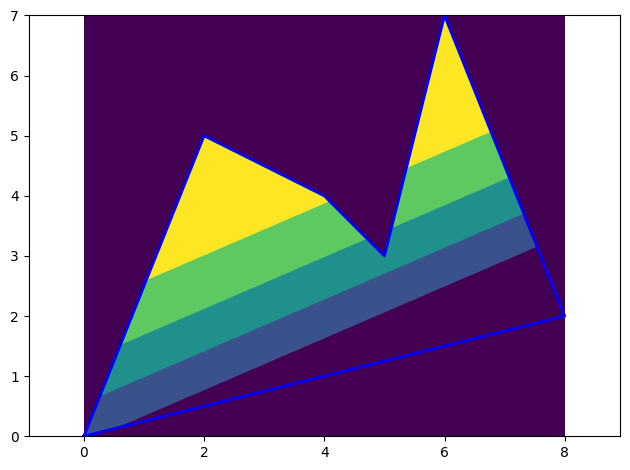

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path

# Polygon input (bentuk bebas, tertutup)
polygon = np.array([
    [0, 0], [2, 5], [4, 4], [5, 3], [6, 7], [8, 2], [0, 0]
])

# Raster canvas (besar = resolusi)
res = 1000
xmin, ymin = polygon.min(axis=0)
xmax, ymax = polygon.max(axis=0)

X, Y = np.meshgrid(np.linspace(xmin, xmax, res), np.linspace(ymin, ymax, res))
points = np.vstack((X.flatten(), Y.flatten())).T

# Mask untuk isi polygon
path = Path(polygon)
mask = path.contains_points(points).reshape(res, res)

# Regresi linear
x_poly, y_poly = polygon[:, 0], polygon[:, 1]
a, b = np.polyfit(x_poly, y_poly, 1)
tangent = np.array([1, a])
tangent = tangent / np.linalg.norm(tangent)
normal = np.array([-a, 1])
normal = normal / np.linalg.norm(normal)

# Proyeksikan seluruh pixel ke arah normal untuk slicing
coords = np.dstack((X, Y))
center = np.mean(polygon, axis=0)
rel_coords = coords - center
proj = rel_coords @ normal  # Dot product, hasilnya shape (res, res)

# Hanya gunakan area dalam polygon
proj_masked = np.where(mask, proj, np.nan)

# Hitung ambang batas pembagian berdasarkan luas
n = 5
area_total = np.sum(mask)
area_per_part = area_total / n

# Iteratif cari threshold proyeksi
thresholds = []
sorted_proj = np.sort(proj_masked[~np.isnan(proj_masked)])
for i in range(1, n):
    idx = int(i * area_per_part)
    thresholds.append(sorted_proj[idx])

# Buat label per area
slices = np.zeros_like(proj_masked, dtype=int)
for i, t in enumerate(thresholds):
    slices[proj_masked >= t] = i + 1

# Visualisasi
plt.imshow(slices, cmap='viridis', origin='lower', extent=(xmin, xmax, ymin, ymax))
plt.plot(polygon[:, 0], polygon[:, 1], color='blue', linewidth=2)
plt.axis("equal")
plt.tight_layout()
plt.show()


In [97]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
import geopandas as gpd 
import shapely as shp

# Sutherland-Hodgman polygon clipping (terhadap convex polygon clip window)
def sutherland_hodgman(subject_polygon, clip_polygon):
    def inside(p, cp1, cp2):
        return (cp2[0] - cp1[0]) * (p[1] - cp1[1]) > (cp2[1] - cp1[1]) * (p[0] - cp1[0])

    def intersection(cp1, cp2, s, e):
        dc = (cp1[0] - cp2[0], cp1[1] - cp2[1])
        dp = (s[0] - e[0], s[1] - e[1])
        n1 = cp1[0] * cp2[1] - cp1[1] * cp2[0]
        n2 = s[0] * e[1] - s[1] * e[0]
        denom = dc[0] * dp[1] - dc[1] * dp[0]
        if denom == 0:
            return None  # parallel
        x = (n1 * dp[0] - n2 * dc[0]) / denom
        y = (n1 * dp[1] - n2 * dc[1]) / denom
        return (x, y)

    output_list = subject_polygon
    cp1 = clip_polygon[-1]
    for cp2 in clip_polygon:
        input_list = output_list
        output_list = []
        if not input_list:
            return []
        s = input_list[-1]
        for e in input_list:
            if inside(e, cp1, cp2):
                if not inside(s, cp1, cp2):
                    output_list.append(intersection(cp1, cp2, s, e))
                output_list.append(e)
            elif inside(s, cp1, cp2):
                output_list.append(intersection(cp1, cp2, s, e))
            s = e
        cp1 = cp2
    return output_list


# Fungsi utama
def split_polygon_equal_by_regression(polygon: List[Tuple[float, float]], n: int) -> List[List[Tuple[float, float]]]:
    coords = np.array(polygon)
    X, Y = coords[:, 0], coords[:, 1]
    
    # Regresi linear y = ax + b
    a, b = np.polyfit(X, Y, 1)
    direction = np.array([1, a])
    direction = direction / np.linalg.norm(direction)
    normal = np.array([-direction[1], direction[0]])  # tegak lurus
    
    centroid = coords.mean(axis=0)
    projections = [(pt - centroid) @ direction for pt in coords]
    min_proj, max_proj = min(projections), max(projections)
    total_length = max_proj - min_proj
    step = total_length / n

    # Buat n potongan grid
    parts = []
    for i in range(n):
        # Tentukan batas bawah dan atas potongan ke-i
        start_proj = min_proj + i * step
        end_proj = min_proj + (i + 1) * step

        # Buat kotak clipping (segiempat) tegak lurus regresi
        center1 = centroid + direction * start_proj
        center2 = centroid + direction * end_proj

        # Buat persegi panjang yang sangat panjang sepanjang normal
        L = 1e5
        p1 = center1 + normal * L
        p2 = center1 - normal * L
        p3 = center2 - normal * L
        p4 = center2 + normal * L

        clip_rect = [tuple(p1), tuple(p2), tuple(p3), tuple(p4)]
        clipped = sutherland_hodgman(polygon, clip_rect)
        if clipped:
            parts.append(clipped)
    
    return parts

def split_polygon_by_area(polygon: List[Tuple[float, float]], target_area: float) -> List[List[Tuple[float, float]]]:
    coords = np.array(polygon)
    X, Y = coords[:, 0].tolist(), coords[:, 1].tolist()
    area_total = 0.5 * abs(np.dot(X, Y[1:] + [Y[0]]) - np.dot(Y, X[1:] + [X[0]]))
    
    from math import ceil
    direction = np.array([1, np.polyfit(X, Y, 1)[0]])
    direction = direction / np.linalg.norm(direction)
    normal = np.array([-direction[1], direction[0]])
    centroid = coords.mean(axis=0)

    projections = [(pt - centroid) @ direction for pt in coords]
    min_proj, max_proj = min(projections), max(projections)
    total_length = max_proj - min_proj

    n = ceil(area_total / target_area)
    step = total_length / n

    parts = []
    for i in range(n):
        start_proj = min_proj + i * step
        end_proj = min_proj + (i + 1) * step
        center1 = centroid + direction * start_proj
        center2 = centroid + direction * end_proj
        L = 1e5
        p1 = center1 + normal * L
        p2 = center1 - normal * L
        p3 = center2 - normal * L
        p4 = center2 + normal * L
        clip_rect = [tuple(p1), tuple(p2), tuple(p3), tuple(p4)]
        clipped = sutherland_hodgman(polygon, clip_rect)
        if clipped:
            parts.append(clipped)
    return parts



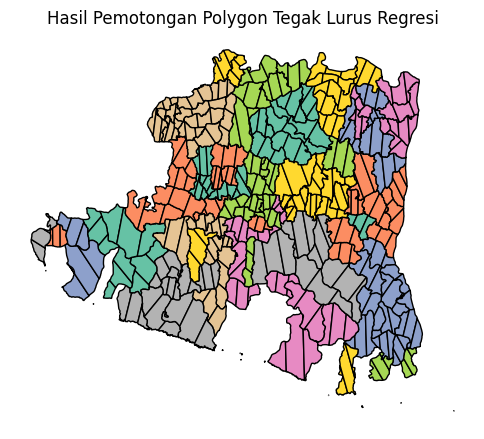

In [96]:
import geopandas as gpd
from shapely.geometry import Polygon

# Baca file GeoJSON (gunakan file dummy karena "testes.geojson" tidak tersedia di sini)
# Simulasi data GeoDataFrame dengan 1 MultiPolygon sederhana
from shapely.geometry import MultiPolygon

# Dummy GeoDataFrame (1 MultiPolygon)
gdf = gpd.read_file("tes_besar_2.geojson")

# Proses: Ambil ring luar, split, simpan hasil dalam GeoSeries
def process_all_polygons(gdf, n=5):
    all_parts = []
    for geom in gdf.geometry:
        if geom.geom_type == "Polygon":
            coords = list(geom.exterior.coords)
        elif geom.geom_type == "MultiPolygon":
            coords = list(geom.geoms[0].exterior.coords)
        else:
            continue
        parts = split_polygon_equal_by_regression(coords, n)
        for part_coords in parts:
            all_parts.append(Polygon(part_coords))
    return gpd.GeoSeries(all_parts)

result_series = process_all_polygons(gdf, n=3)

# Visualisasi
ax = result_series.plot(figsize=(6, 6), cmap="Set2", edgecolor="black")
ax.set_title("Hasil Pemotongan Polygon Tegak Lurus Regresi")
ax.set_axis_off()
plt.show()
result_series.to_file("hasil_split.geojson", driver="GeoJSON")

